In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
endangered = pd.read_csv('./data/endangered_species.csv')
production = pd.read_csv('./data/world_production_new.csv')
threat = pd.read_csv('./data/threatened_species_by_country.csv')


In [45]:
# convert the years that have the format 2014-3 into 2014

def convert_year(year):
	'''
	Converts the year into a consistent format (for example: from 2014-3 to 2014)
	
	year (string): the year to be converted
	return (string): the converted year
	'''
	year = str(year)
	if '-' in year:
		year = year.split('-')[0]
		year = str(int(year))
		return float(year)
	elif '.' in year:
		year = year.split('.')[0]
		year = str(int(year))
		return float(year)
	elif '‐' in year:
		year = year.split('‐')[0]
		year = str(int(year))
		return float(year)
	else:
		return float(year)

endangered['Year'] = endangered['Year'].apply(convert_year)

# replace commas in numbers and turn total column into integers
threat['Total'] = threat['Total'].str.replace(',', '').astype(int)
threat['Plants*'] = threat['Plants*'].str.replace(',', '').astype(int)


<BarContainer object of 10013 artists>

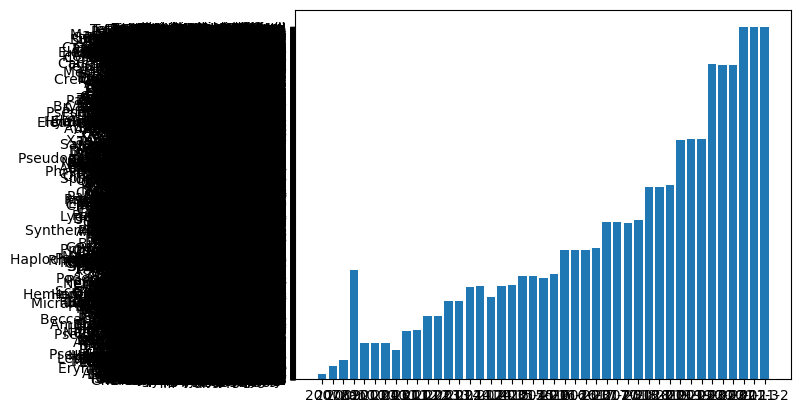

In [5]:
# Make a bar graph of the endangered species by year to see data (takes about 5 minutes to run)

#plt.bar(endangered['Year'].astype(str), endangered['Scientific Name'].astype(str), label='Endangered Species')

<BarContainer object of 14 artists>

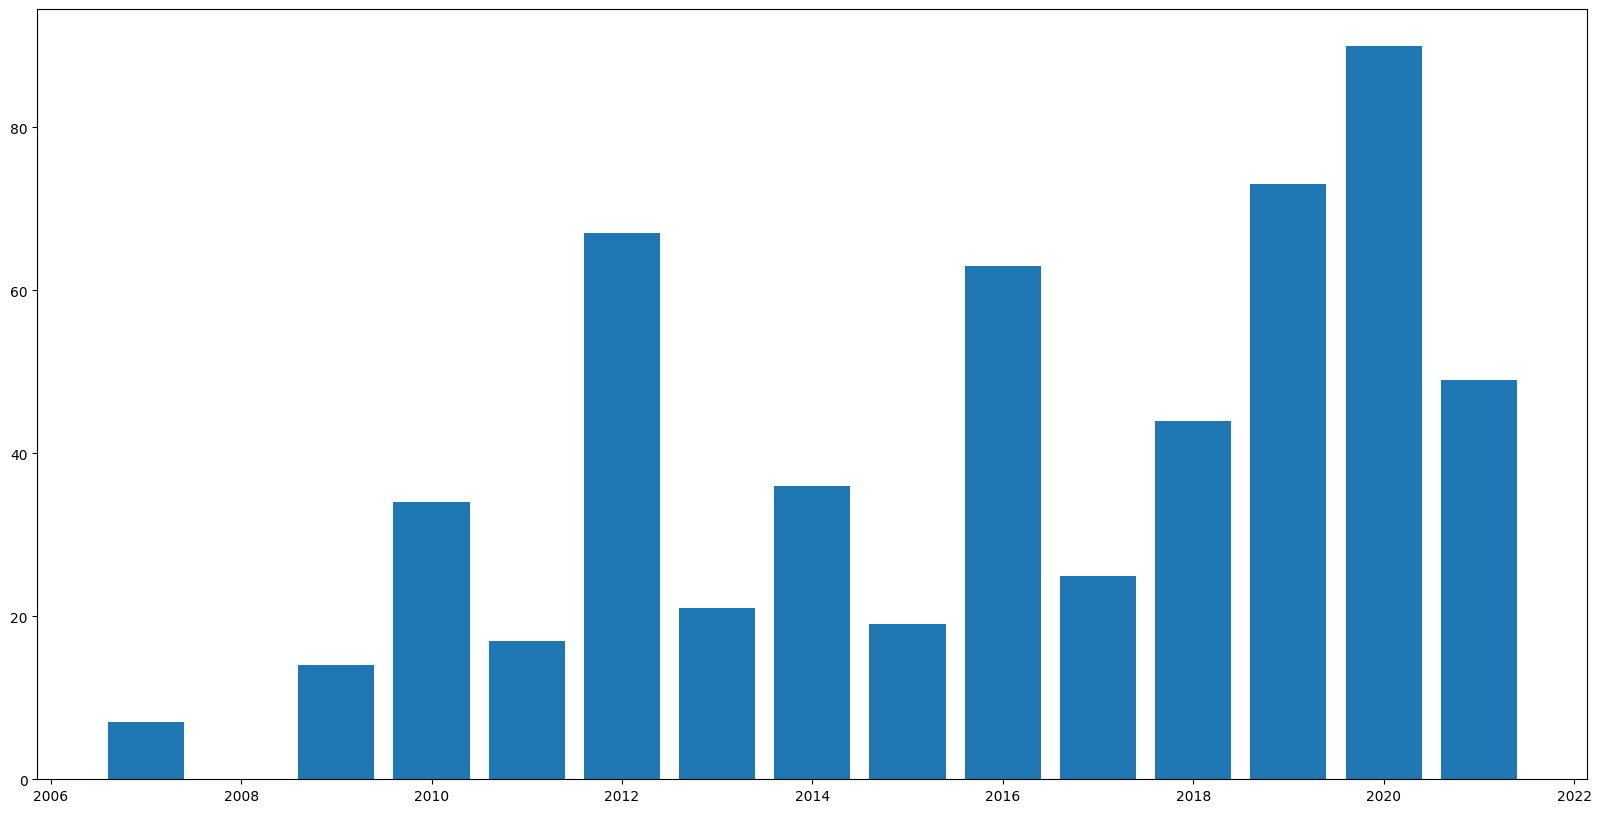

In [54]:
# make a bar graph of the endangered species by year, removing all N and E rows to see data 

# Filter 'endangered' dataframe
endangered_filtered = endangered[endangered['Reason For Change'].isin(['G'])]
endangered_sublist = ['EX', 'EW', 'CR', 'CR(PE)', 'CR(PEW)' 'EN', 'VU']

endangered_critically_endangered = endangered_filtered[endangered_filtered['IUCN Red List Category'].isin(endangered_sublist)]

# Group by 'Year' and count number of occurrences
endangered_year = endangered_critically_endangered.groupby('Year').count().astype(int)
endangered_year = endangered_year.reset_index()

# Select only 'Year' and 'Scientific Name' columns
endangered_year_filtered = endangered_year[['Year', 'Scientific Name']]

# Rename 'Scientific Name' column to 'Species Count'
endangered_year_filtered = endangered_year_filtered.rename(columns={'Scientific Name': 'Species Count'})

# Make bar graph
plt.figure(figsize=(20,10))
plt.bar(x=endangered_year_filtered['Year'], height=endangered_year_filtered['Species Count'])
# plt.scatter(endangered['Year'].astype(str), endangered['Scientific Name'].astype(str), label='Endangered Species')

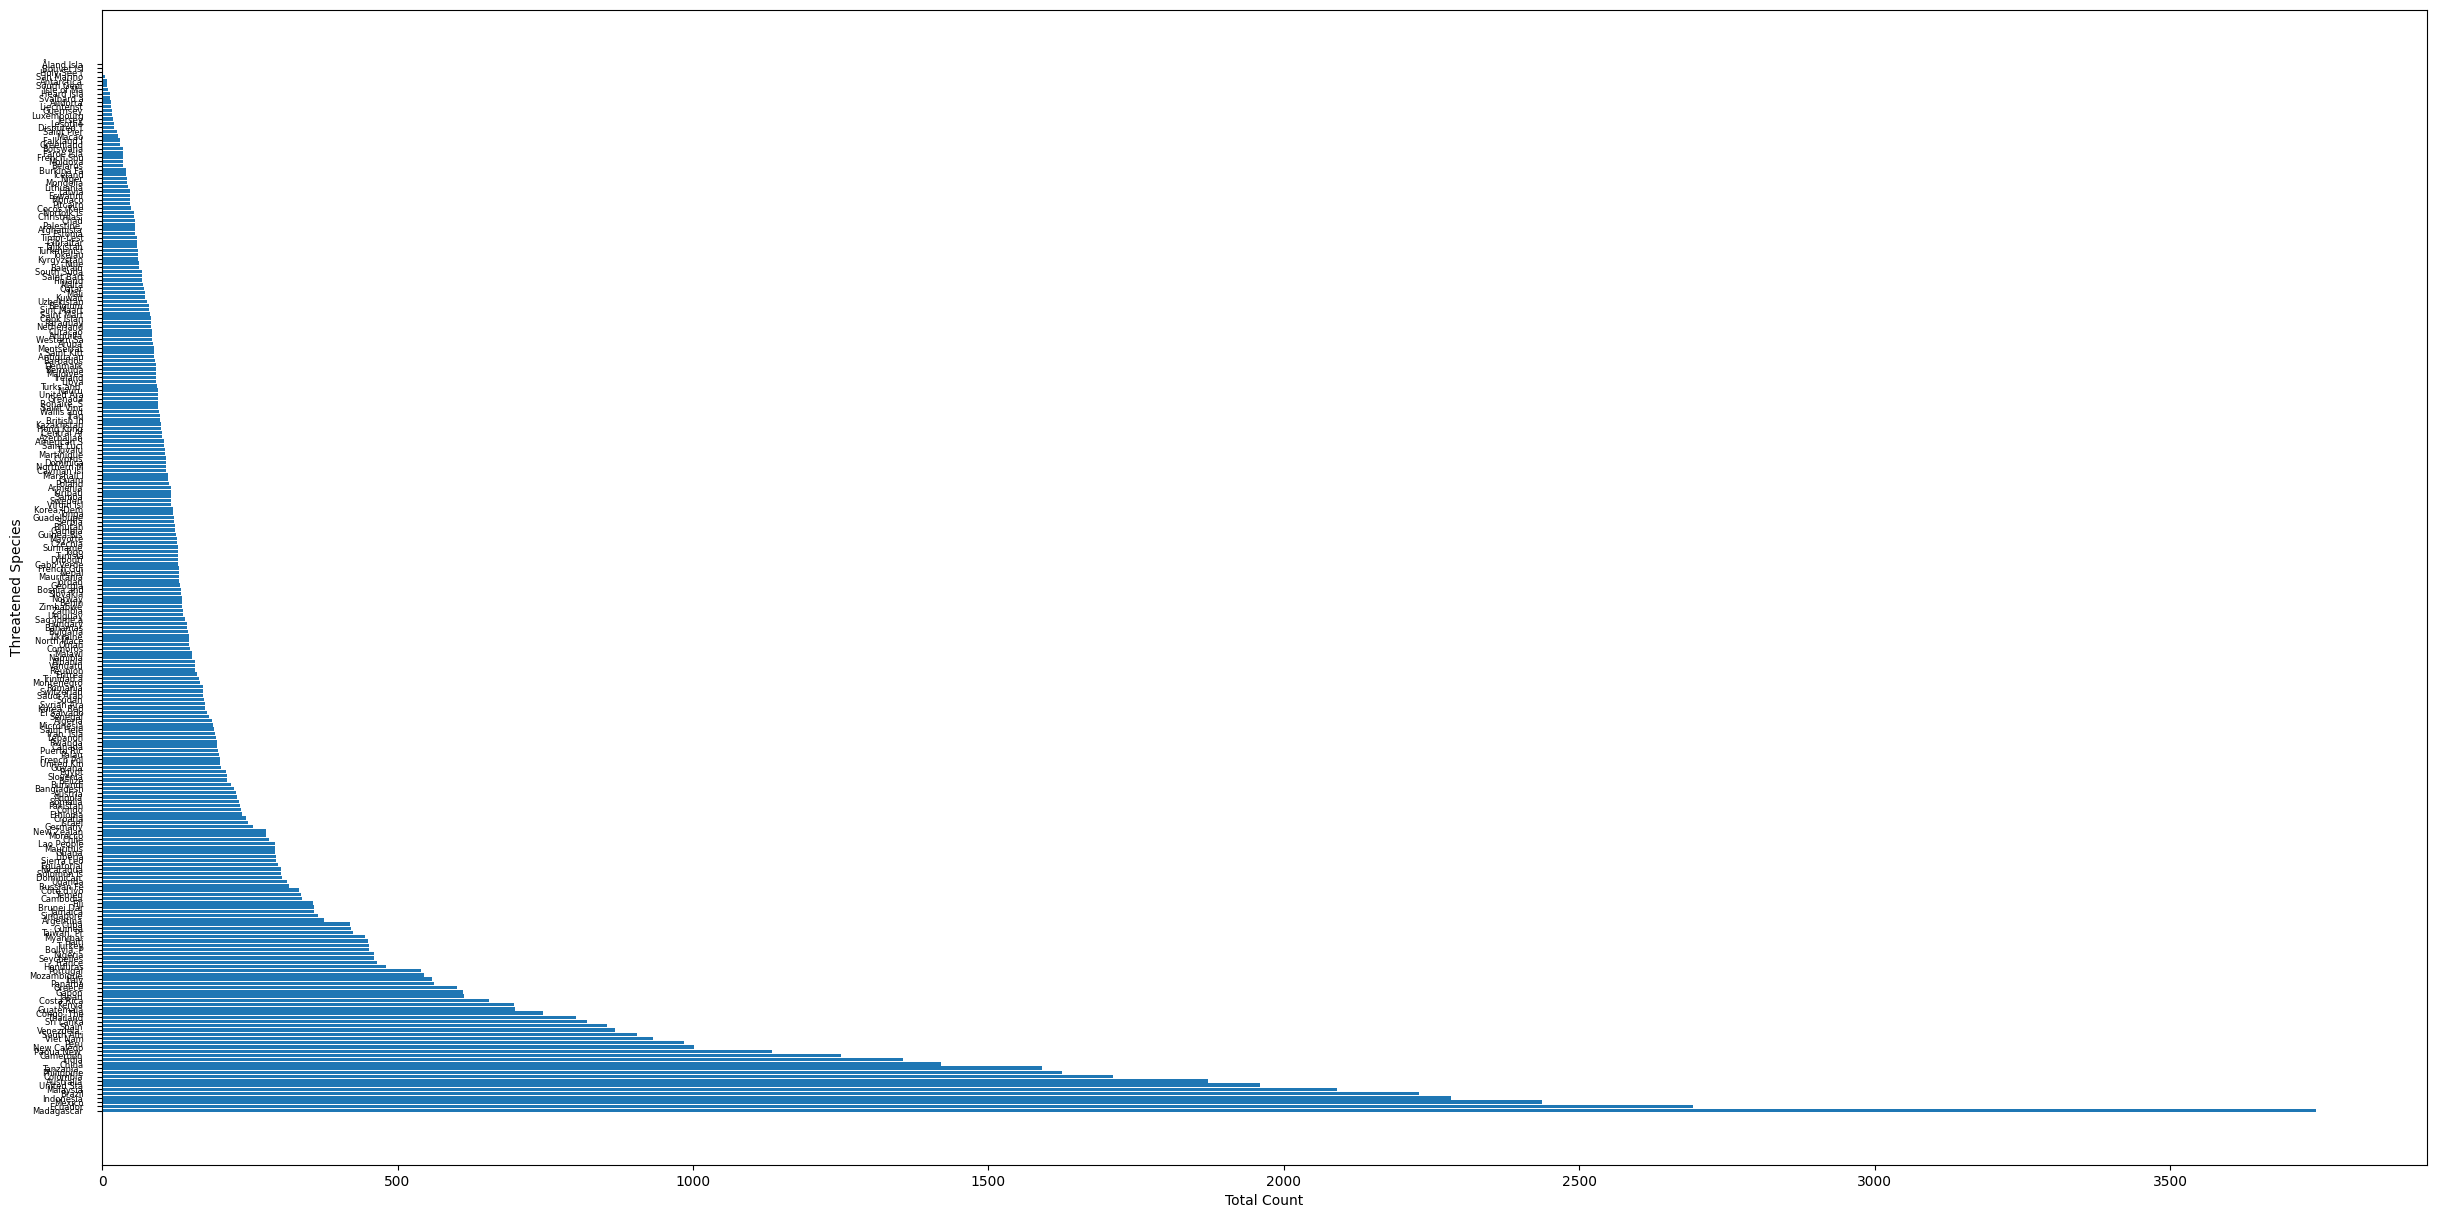

In [105]:
# Make a bar graph of the threatened species by kind to see data

# Group threat dataframe by Name and sum the Total column for each group
threat_filtered = threat.groupby('Name')['Total'].sum().sort_values(ascending=False).reset_index()

# Abbreviate the y-axis tick labels to the first 10 characters
abbreviated_labels = [label[:10] for label in threat_filtered['Name']]

# Create a horizontal bar graph with abbreviated y-values and widths from the Total column
fig, ax = plt.subplots(figsize=(30, 15))
ax.barh(y=abbreviated_labels, width=threat_filtered['Total'], height=0.8)

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Count')
ax.set_ylabel('Threatened Species')

# Reduce font size of y-axis tick labels for readability and adjust spacing
ax.tick_params(axis='y', labelsize=6, pad=10)

plt.show()

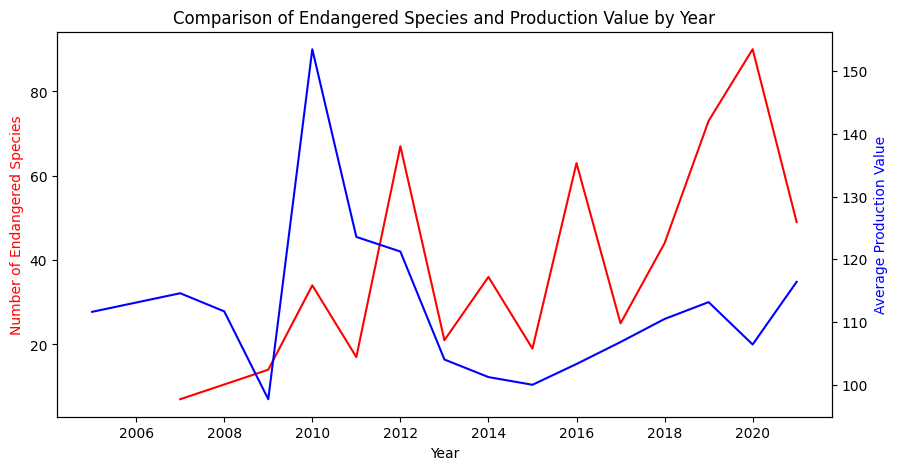

In [73]:
#Compare the average rate of production by year with the number of endangered species by year

# Filter 'production' dataframe by removing 2006 and 2022 and sorting by Year
world_production = production[~production['Year'].isin([2006, 2022])].reset_index(drop=True)

# Calculate the mean production value by year
world_production_avg = world_production.groupby('Year')['Value'].mean().reset_index()
world_production_avg = world_production_avg.rename(columns={'Value': 'Production Value'})

# Group the endangered species data by year

# Plot the two trends on the same chart
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(endangered_year_filtered['Year'], endangered_year_filtered['Species Count'], color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Endangered Species', color='red')

ax2 = ax1.twinx()
ax2.plot(world_production_avg['Year'], world_production_avg['Production Value'], color='blue')
ax2.set_ylabel('Average Production Value', color='blue')

plt.title('Comparison of Endangered Species and Production Value by Year')
plt.show()


In [108]:
#Compare the type of production in each country with the type of endangered species in each country

# Group the production dataframe by Country and Type and count the number of occurrences for each group
prod_by_country_type = production.groupby(['Country', 'Type']).size().reset_index(name='Count')

# Group the endanger dataframe by Country and Type and sum the Total column for each group
threat_by_country_type = threat.groupby(['Country', 'Type'])['Total'].sum().reset_index()

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))

# Create a bar graph of the production types in each country
sns.barplot(x='Count', y='Country', hue='Type', data=prod_by_country_type, ax=ax1)
ax1.set_xlabel('Number of Occurrences')
ax1.set_ylabel('Country')
ax1.set_title('Production Types by Country')

# Create a bar graph of the endangered species by type in each country
sns.barplot(x='Total', y='Country', hue='Type', data=endanger_by_country_type, ax=ax2)
ax2.set_xlabel('Number of Species')
ax2.set_ylabel('Country')
ax2.set_title('Endangered Species by Type')

plt.tight_layout()
plt.show()

KeyError: 'Country'